# Workspace \#6: ``data.py``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt

/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [3]:
# The contents of data.py
dir(dt)

['Simbad',
 'SkyCoord',
 'SuperNova',
 'SuperNovaRemnant',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'clean_white_spaces',
 'ct',
 'data_path',
 'datetime',
 'gen_SN_with_table2',
 'load_Bietenholz',
 'load_Green_catalogue',
 'load_Green_catalogue_names',
 'load_table2',
 'np',
 'os',
 're',
 'simbad_to_galactic',
 'test2',
 'update_Bietenholz_with_coord',
 'update_Bietenholz_with_table2']

### For more: see ``data.ipynb``

## 1. Data Exploration

### 1.1 SN data (Bietenholz)

Warning: 

it seems that Bietenholz only published 108 new SNe in machine readable format. The rest is just collected from old measurements. Perhaps it is easier to just use their $t_{peak}$ $L_{peak}$ fit rather than re-inventing the wheel. Large portion of this section will not to be used. Stop now and proceed with fitted $L_{peak}$ $t_{peak}$ as Manuel did

Loading Bietenholz's Table 1:

In [4]:
# Bietenholz Table 1
table1_path = '../data/Table1_complete_ascii.txt'
SNe = dt.load_Bietenholz(table1_path)

print('%s' %(list(SNe.keys())[1:10]))
print(len(SNe.keys())) # SN1008in seems a typo: ought to be SN2008in; see, v.g., arXiv:1306.5122

['SN1008in', 'SN1995X', 'SN2011cb', 'SN1992ad', 'SN2000P', 'SN2006ov', 'SN1997dq', 'SN2012A', 'SN2009hd']
108


In [5]:
print([key for key in SNe.keys() if '008' in key])

['SN2008X', 'SN1008in', 'SN2008ax', 'SN2008bo', 'SN2008jb']


Loading Bietenholz's Table 2:

In [6]:
# Bietenholz Table 2
table2_path = '../data/Table2_extended_SN_info.txt'
table2 = dt.load_table2(table2_path)
# table2['SN1979C']

dt.update_Bietenholz_with_table2(SNe, table2)
print(len(table2.keys()))

SN1008in failed updating
SN1988S failed updating
294


In [7]:
list(SNe.items())[2][1].__dict__

{'comment': array(['Weiler', 'Weiler', 'Weiler', 'Weiler'], dtype='|S32'),
 'day': array([15.,  9., 17., 17.]),
 'detected': None,
 'dflux': array([0.112, 0.048, 0.034, 0.059]),
 'dist': None,
 'distance': 25.5,
 'explosion_date': '1995 08 03',
 'flux': array([-0.336, -0.143, -0.102, -0.177]),
 'freq': array([8.46, 8.46, 8.46, 4.86]),
 'galaxy': 'UGC 12160',
 'has_explosion_time': False,
 'is_limit': array([ True,  True,  True,  True]),
 'month': array([ 9.,  6.,  6., 10.]),
 'name': 'SN1995X',
 'number_of_measurements': None,
 't': array([], dtype=float64),
 'telescope': array(['VLA    ', 'VLA    ', 'VLA    ', 'VLA    '], dtype='|S32'),
 'type': 'II',
 'year': array([1995., 1998., 1998., 2000.])}

In [8]:
freqs = []
for name, data in SNe.items():
    sn_dict = data.__dict__
    
    try:
        freq = sn_dict['freq']
        freqs.append(freq)
    except:
        continue

factors = [(1./nu)**-0.8 for nu in freqs]

In [9]:
avg_freqs = np.array([f_arr.mean() for f_arr in freqs])
# avg_freqs = np.array([np.median(f_arr) for f_arr in freqs])

print(len(avg_freqs), avg_freqs.mean(), avg_freqs.std())

(108, 7.99524358974359, 2.5289175433962154)


In [10]:
avg_factors = np.array([ft_arr.mean() for ft_arr in factors])
print(len(avg_factors), avg_factors.mean(), avg_factors.std())
print(avg_factors.std()/avg_factors.mean())

(108, 5.226613554986191, 1.2050365767568738)
0.23055781034495434


Finding the coordinates:

In [11]:
# query the coord of the galaxies from Simbad
dt.update_Bietenholz_with_coord(SNe, use_Simbad=True)

# reuse local cache from query of Simbad
dt.update_Bietenholz_with_coord(SNe, use_Simbad=False)

/home/buenabad/anaconda2/lib/python2.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 4 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : SN 1008in
  (error.line, error.msg))


SN1987K failed the query
SN1987K failed the query


In [12]:
# example:
# SNe['SN2010as'].__dict__
SNe['SN1008in'].__dict__ # note the year of SN1008in

{'comment': array([''], dtype='|S32'),
 'day': array([31.36]),
 'detected': None,
 'dflux': array([0.076]),
 'dist': None,
 'explosion_date': None,
 'flux': array([-0.227]),
 'freq': array([8.46]),
 'galaxy': None,
 'has_explosion_time': False,
 'is_limit': array([ True]),
 'month': array([12.]),
 'name': 'SN1008in',
 'number_of_measurements': None,
 't': array([], dtype=float64),
 'telescope': array(['VLA    '], dtype='|S32'),
 'type': None,
 'year': array([2008.])}

Plotting lightcurves:

In [13]:
import numpy.ma as ma

In [14]:
for name, SN in SNe.items():
    SN.gen_time_axis()

None
None


106

/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


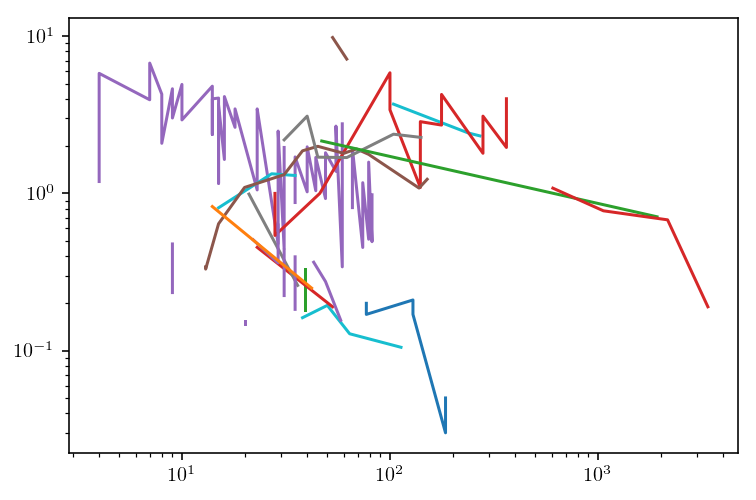

In [15]:
plt.subplots()
n = 0

for name, SN in SNe.items():
    if not SN.has_explosion_time:
        print(SN.explosion_date)
        continue
    n += 1
    mask = SN.is_limit
    t = ma.masked_array(SN.t, mask=mask)
    flux = ma.masked_array(SN.flux, mask=mask)
    plt.loglog(t, flux)
    #plt.loglog((SN.t), (SN.flux))
    #plt.loglog(np.abs(SN.t), np.abs(SN.flux))
n

### 1.2 Green's Catalogue

In [16]:
# first let's parse snrs.list.html
# names:
path = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/snrs.list.html'
snr_name_arr = dt.load_Green_catalogue_names(path=path)

# catalogue:
pathroot = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/'
snrs_dct = dt.load_Green_catalogue(snr_name_arr, pathroot=pathroot, verbose=0)

G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.6+14.6 is suggested to be related to SN explosion at AD:1006
it is about 1015 years old.


In [17]:
name = 'G8.9+0.4'

print(snrs_dct[name].get_spectral_index())
print(snrs_dct[name].is_spectral_certain)
print(snrs_dct[name].get_type())
print(snrs_dct[name].is_type_certain)

del name

0.6
True
S
True


In [18]:
# luminosity v. diameter
path = '../data/Green_2005_lum_diam.csv'
green2005_lum_diam_arr = np.loadtxt(path, delimiter=',')

# surface brightness v. diameter
path = '../data/Green_2005_SB_diam.csv'
green2005_SB_diam_arr = np.loadtxt(path, delimiter=',')

In [19]:
# length of catalogues
print(len(snrs_dct))
print(len(green2005_lum_diam_arr))
print(len(green2005_SB_diam_arr))

294
47
47


In [20]:
dir(snrs_dct['G337.0-0.1'])

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alpha',
 'ang_size',
 'b',
 'get_SB',
 'get_age',
 'get_coord',
 'get_diameter',
 'get_distance',
 'get_flux_density',
 'get_latitude',
 'get_longitude',
 'get_luminosity',
 'get_size',
 'get_spectral_index',
 'get_type',
 'is_complete',
 'is_flux_certain',
 'is_spectral_certain',
 'is_type_certain',
 'l',
 'name',
 'no_dist',
 'no_flux',
 'set_age',
 'set_coord',
 'set_distance',
 'set_flux_density',
 'set_name',
 'set_size',
 'set_spectral',
 'set_sr',
 'set_type',
 'snu_at_1GHz',
 'sr',
 'type']

## 2. Scatter plots

#### $L_\nu$ vs diameter

/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


294

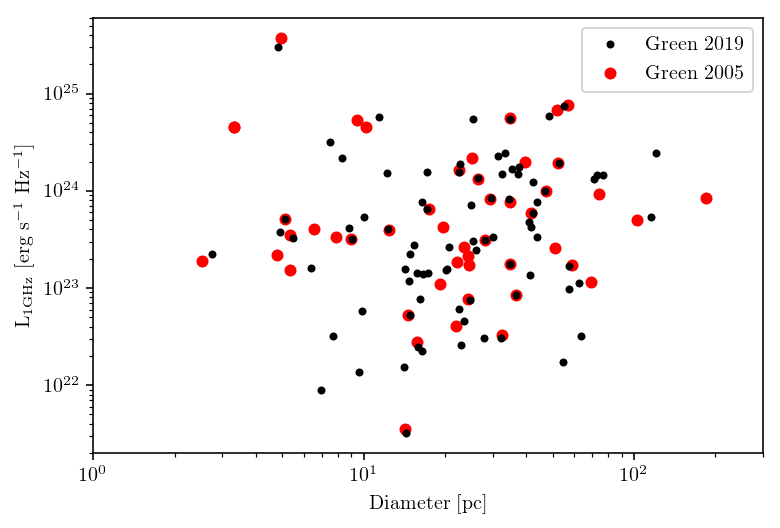

In [21]:
counter = 0

# lum plot and compare with Green 2005
plt.subplots()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Diameter [pc]')
plt.ylabel(r'L$_{1\mathrm{GHz}}$ [erg s$^{-1}$ Hz$^{-1}$]')
plt.xlim(1, 300)

for _, snr in snrs_dct.items():
        diam = snr.get_diameter()
        lum = snr.get_luminosity()
        plt.plot(diam, lum, 'k.')
        counter += 1
plt.plot(diam, lum, 'k.', label='Green 2019')

# compare with Green 2005
_J_over_erg_ = 1.e7
plt.plot(green2005_lum_diam_arr[:,0], green2005_lum_diam_arr[:,1]*_J_over_erg_, 'ro', markersize=5, zorder=0)
plt.plot(green2005_lum_diam_arr[1,0], green2005_lum_diam_arr[1,1]*_J_over_erg_, 'ro', markersize=5, zorder=0, label='Green 2005')

plt.legend(loc='best')

counter

#### $\Sigma_\nu$ vs diameter

84

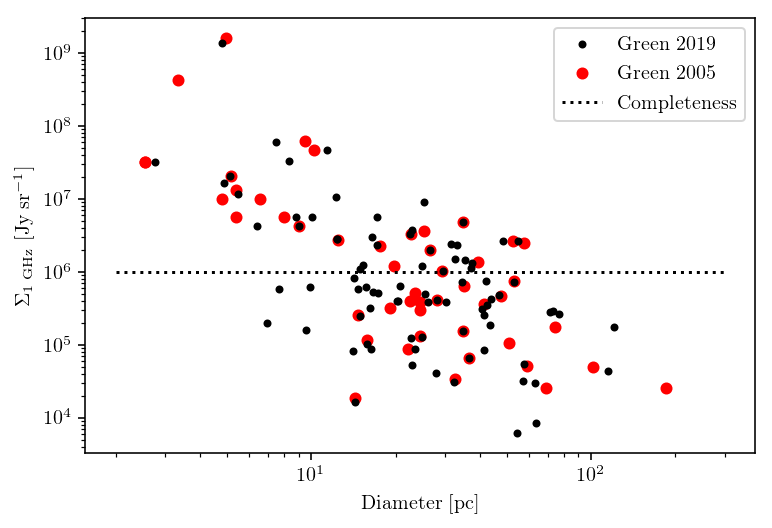

In [22]:
counter = 0

# Sigma plot
plt.subplots()
plt.yscale('log')
plt.xscale('log')
# plt.xlabel('Distance [kpc]')
plt.xlabel('Diameter [pc]')
plt.ylabel(r'$\Sigma_{1\;\mathrm{GHz}}$ [Jy sr$^{-1}$]')

for _, snr in snrs_dct.items():
    if snr.no_dist is False and snr.no_flux is False:        
        diam = snr.get_diameter()
        Sigma = snr.get_SB()
        plt.plot(diam, Sigma, 'k.')
        counter += 1
        
plt.plot(green2005_SB_diam_arr[:,0], green2005_SB_diam_arr[:,1]/ct._Jy_over_SI_, 'ro', markersize=5, zorder=0)

# completeness cut
plt.hlines(1e-20 / ct._Jy_over_SI_, 2, 300, linestyles=":", label='Completeness')

# labels
plt.plot(diam, Sigma, 'k.', label='Green 2019')
plt.plot(green2005_SB_diam_arr[0,0], green2005_SB_diam_arr[0,1]/ct._Jy_over_SI_, 'ro', markersize=5, zorder=0, label='Green 2005')
plt.legend(loc='best')

counter

#### $S_\nu$ vs distance

84

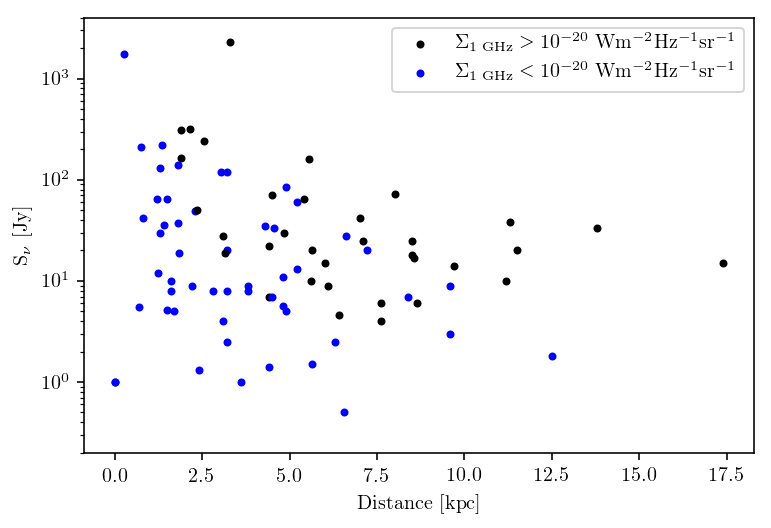

In [23]:
counter = 0

plt.subplots()
plt.yscale('log')
plt.xlabel('Distance [kpc]')
plt.ylabel(r'S$_\nu$ [Jy]')
plt.ylim(0.2, 4000)

for _, snr in snrs_dct.items():
    if snr.no_dist is False and snr.no_flux is False:
        snr.get_SB()
        if snr.is_complete:        
            plt.plot(snr.distance, snr.snu_at_1GHz, 'k.')
        else:
            plt.plot(snr.distance, snr.snu_at_1GHz, 'b.')
        counter += 1
        
# labels
plt.plot([1,0.01], 'k.', label='$\Sigma_{1\;\mathrm{GHz}} > 10^{-20} \;\mathrm{Wm^{-2} Hz^{-1}sr^{-1}}$')
plt.plot([1,0.01], 'b.', label='$\Sigma_{1\;\mathrm{GHz}} < 10^{-20} \;\mathrm{Wm^{-2} Hz^{-1}sr^{-1}}$')
plt.legend(loc='best')
counter

#### $L_\nu$ vs distance

34

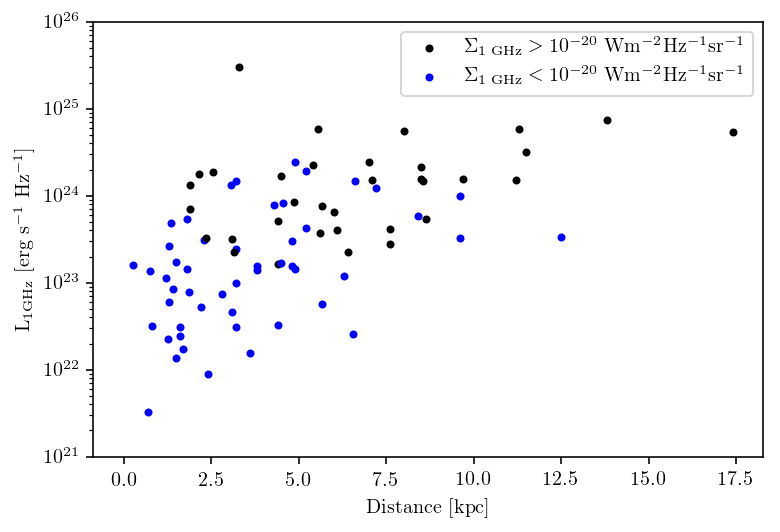

In [24]:
# lum plot
plt.subplots()
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Distance [kpc]')
plt.ylabel(r'L$_{1\mathrm{GHz}}$ [erg s$^{-1}$ Hz$^{-1}$]')
plt.ylim(1e21, 1e26)

counter = 0
for _, snr in snrs_dct.items():
    if snr.no_dist is False and snr.no_flux is False:
        dist = snr.distance
        snu = snr.snu_at_1GHz
        lum = snr.get_luminosity()
        snr.get_SB()
        if snr.is_complete:
            plt.plot(snr.distance, lum, 'k.')
            counter += 1
        else:
            plt.plot(snr.distance, lum, 'b.')

# labels
plt.plot([1,0.01], 'k.', label='$\Sigma_{1\;\mathrm{GHz}} > 10^{-20} \;\mathrm{Wm^{-2} Hz^{-1}sr^{-1}}$')
plt.plot([1,0.01], 'b.', label='$\Sigma_{1\;\mathrm{GHz}} < 10^{-20} \;\mathrm{Wm^{-2} Hz^{-1}sr^{-1}}$')
plt.legend(loc='best')

counter

## 3. Histograms

In [25]:
# first let's parse snrs.list.html
# names:
path = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/snrs.list.html'
snr_name_arr = dt.load_Green_catalogue_names(path=path)

# catalogue:
pathroot = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/'
snrs_dct = dt.load_Green_catalogue(snr_name_arr, pathroot=pathroot, verbose=0)

G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.6+14.6 is suggested to be related to SN explosion at AD:1006
it is about 1015 years old.


In [26]:
snrs_cut = {}
for name, snr in snrs_dct.items():
    
    try:
        snr.distance
    except:
#         print "no distance:", name
        continue
    
    try:
        snr.alpha
    except:
        continue
    
    if snr.get_flux_density() == -1:
        print("no flux density: "+str(name))
        continue
    
    if not snr.is_flux_certain:
        print("uncertain flux: "+str(name))
        continue
    
    snrs_cut[name] = snr
    
print(len(snrs_cut))

uncertain flux: G49.2-0.7
uncertain flux: G39.7-2.0
no flux density: G85.9-0.6
no flux density: G181.1+9.5
uncertain flux: G344.7-0.1
uncertain flux: G32.8-0.1
uncertain flux: G327.4+0.4
uncertain flux: G330.2+1.0
uncertain flux: G82.2+5.3
uncertain flux: G316.3-0.0
uncertain flux: G350.1-0.3
uncertain flux: G320.4-1.2
uncertain flux: G5.4-1.2
no flux density: G85.4+0.7
61


In [27]:
for name, snr in snrs_cut.items():
    print(name+" size:  \t%.1e" % snr.get_size())

G352.7-0.1 size:  	3.2e-06
G349.7+0.2 size:  	3.3e-07
G11.2-0.3 size:  	1.1e-06
G292.0+1.8 size:  	6.4e-06
G296.8-0.3 size:  	1.9e-05
G18.1-0.1 size:  	4.3e-06
G53.6-2.2 size:  	6.1e-05
G54.4-0.3 size:  	1.1e-04
G35.6-0.4 size:  	1.1e-05
G39.2-0.3 size:  	3.2e-06
G89.0+4.7 size:  	7.2e-04
G34.7-0.4 size:  	6.3e-05
G94.0+1.0 size:  	5.0e-05
G4.5+6.8 size:  	6.0e-07
G337.2-0.7 size:  	2.4e-06
G18.6-0.2 size:  	2.4e-06
G260.4-3.4 size:  	2.0e-04
G18.8+0.3 size:  	1.2e-05
G15.4+0.1 size:  	1.4e-05
G20.0-0.2 size:  	6.6e-06
G54.1+0.3 size:  	9.6e-06
G304.6+0.1 size:  	4.3e-06
G116.5+1.1 size:  	3.2e-04
G108.2-0.6 size:  	2.5e-04
G109.1-1.0 size:  	5.2e-05
G33.6+0.1 size:  	6.6e-06
G113.0+0.2 size:  	4.5e-05
G290.1-0.8 size:  	1.8e-05
G205.5+0.5 size:  	3.2e-03
G111.7-2.1 size:  	1.7e-06
G23.3-0.3 size:  	4.8e-05
G21.8-0.6 size:  	2.7e-05
G119.5+10.2 size:  	5.4e-04
G24.7-0.6 size:  	1.5e-05
G46.8-0.3 size:  	1.5e-05
G332.4-0.4 size:  	6.6e-06
G29.7-0.3 size:  	6.0e-07
G292.2-0.5 size:  	2.0

In [28]:
alphas = []
for name, snr in snrs_cut.items():
    alpha = snr.__dict__['alpha']
    alphas.append(alpha)
alphas = np.array(alphas)

/home/buenabad/Documents/codes/git_codes/snr_ghosts/workspace_notebooks/plots/snr_properties/GC_alpha_dist.pdf


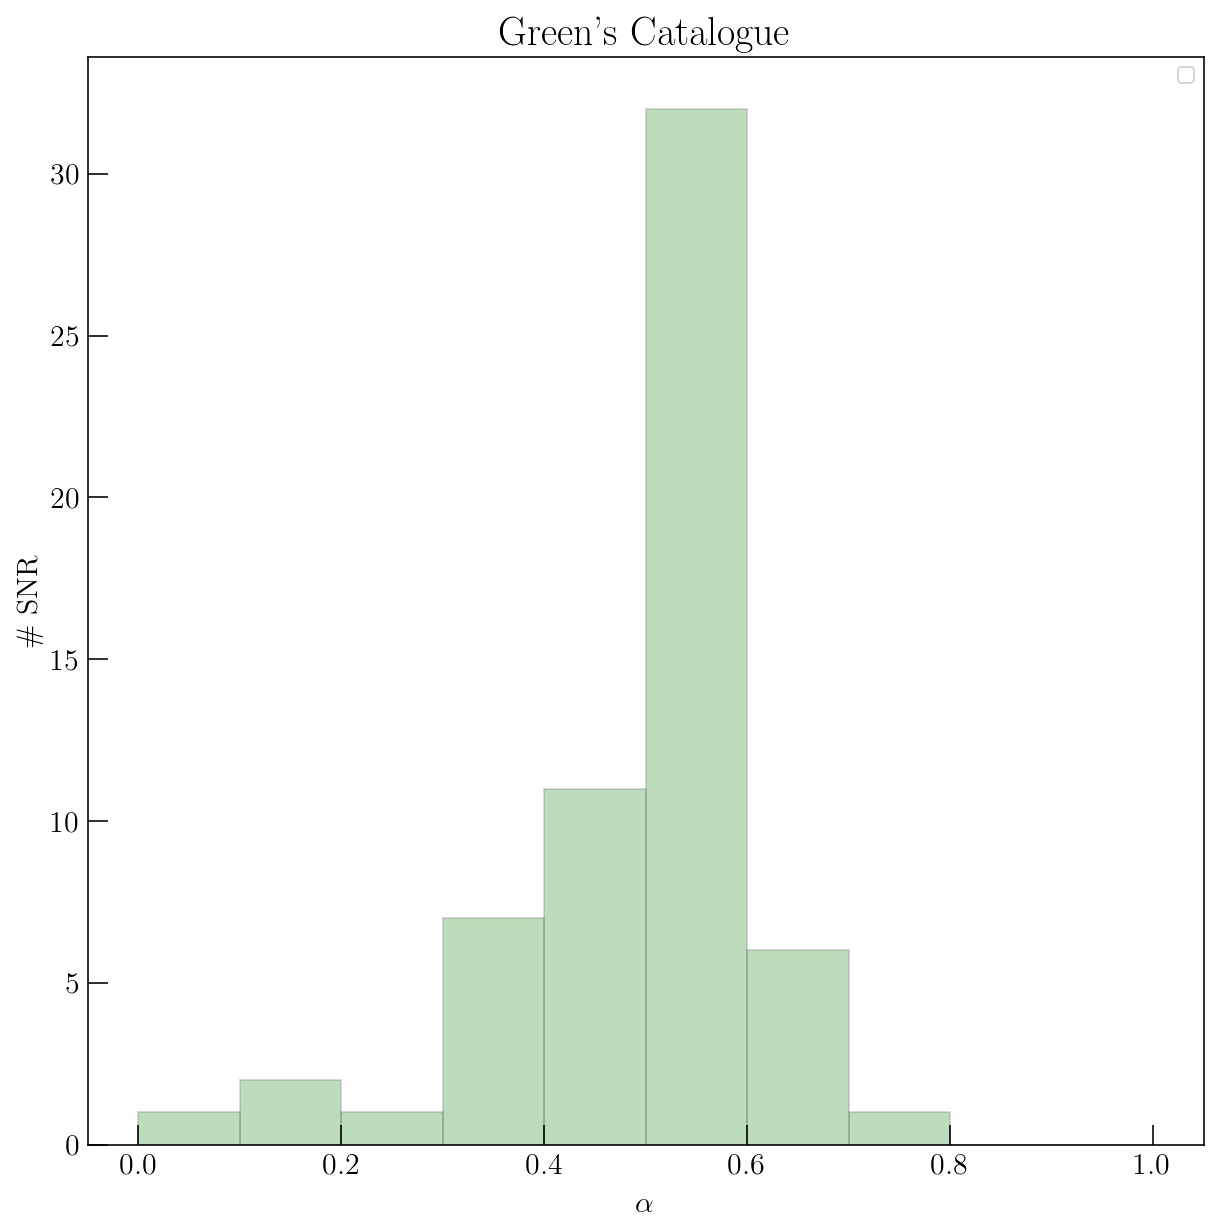

In [29]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

bins = np.linspace(0., 1., 11);
plt.hist(alphas,
         bins=bins,
         alpha=0.3,
         color='forestgreen',
         ec='grey'
        )

title = "Green's Catalogue";
plt.title(title, fontsize=title_sz);

plt.ylabel(r"\# SNR", fontsize=label_sz);
plt.xlabel(r"$\alpha$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);
plt.legend(loc='best');

file_name = current_dir+"/plots/snr_properties/GC_alpha_dist.pdf"
print(file_name)

# plt.savefig(file_name, bbox_inches="tight")

/home/buenabad/Documents/codes/git_codes/snr_ghosts/workspace_notebooks/plots/snr_properties/GC_nu-fac_dist.pdf


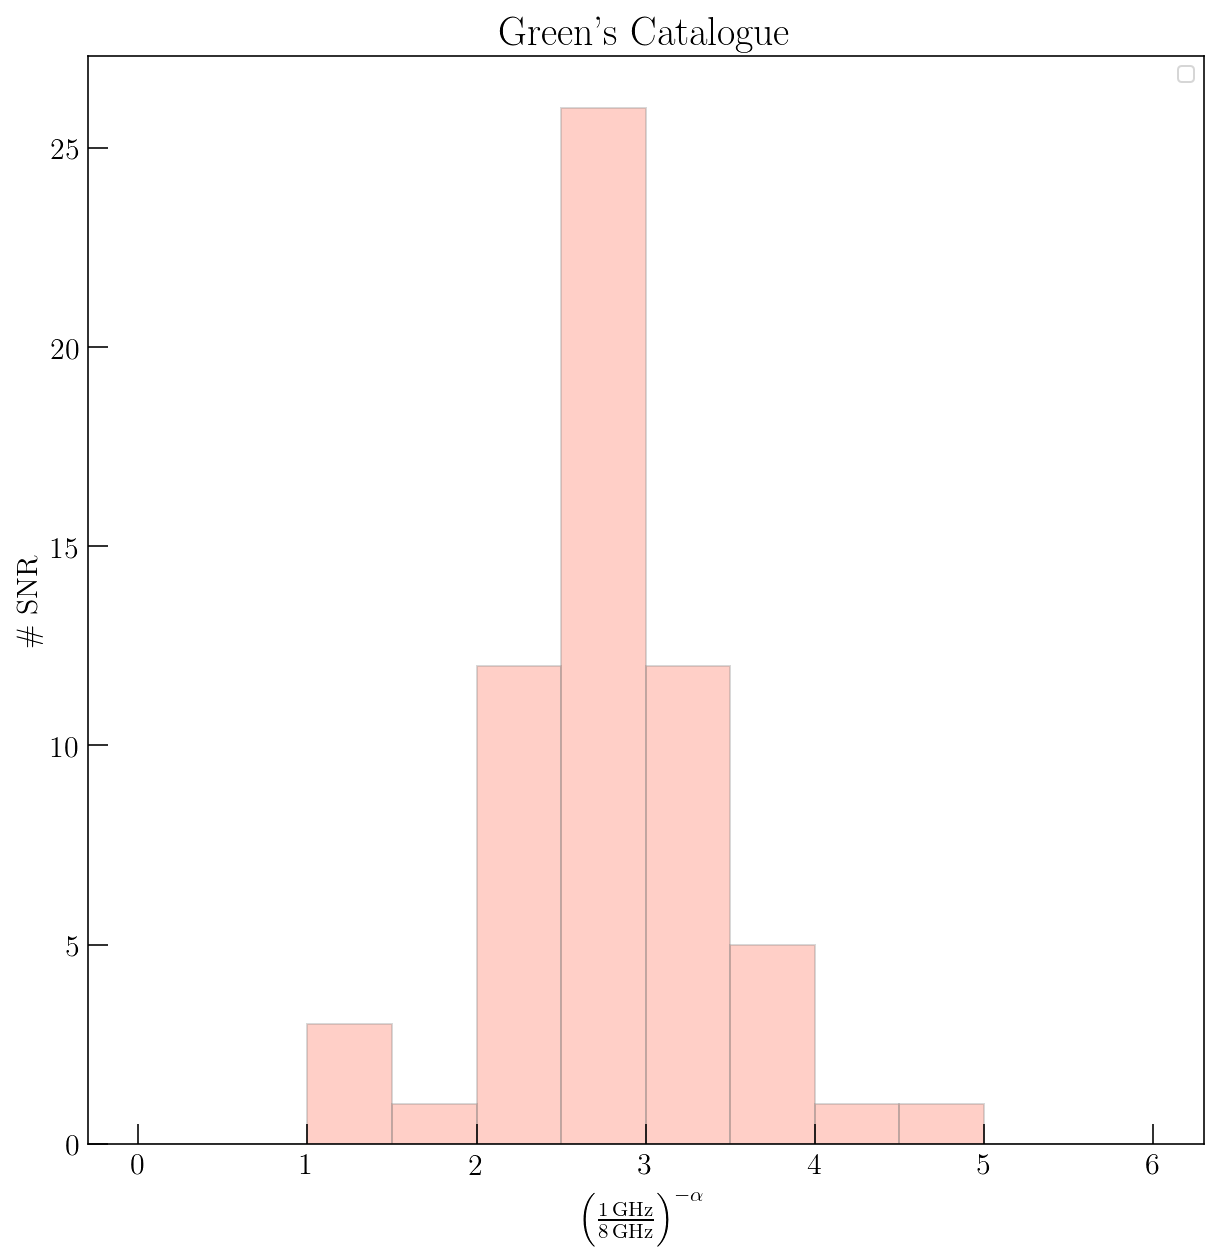

In [30]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

bins = np.linspace(0., 6., 13);

nu_facs = ap.nu_factor(1., 8., alphas)

plt.hist(nu_facs,
         bins=bins,
         alpha=0.3,
         color='tomato',
         ec='grey'
        )

title = "Green's Catalogue";
plt.title(title, fontsize=title_sz);

plt.ylabel(r"\# SNR", fontsize=label_sz);
plt.xlabel(r"$\bigg( \frac{1\,\mathrm{GHz}}{8\,\mathrm{GHz}} \bigg)^{-\alpha}$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);
plt.legend(loc='best');

file_name = current_dir+"/plots/snr_properties/GC_nu-fac_dist.pdf"
print(file_name)

# plt.savefig(file_name, bbox_inches="tight")

### For more details about what can be done with ``data.py`` (e.g. histograms of the distributions in $\alpha$, $\theta_{\rm size}$, $L_\nu$, $\Sigma_\nu$, or diameters), see ``data.ipynb``
(``data.ipynb`` is essentially a shameless copy of Chen's fine ``snr_ghosts_busters.ipynb`` (version 1))